In [7]:
from botorch.utils.sampling import draw_sobol_samples
import FewShotCVRP.bo.bo_torch as bo_torch
import torch


def sample(bounds_t, n, q, seed):
    X = draw_sobol_samples(bounds=bounds_t, n=n, q=q, seed=seed).squeeze(-2)
    return bo_torch._to_numpy64(X)


sample(torch.tensor(([-5.0, -5.0, -1.0], [5.0, 5.0, 1.0])), 10, 1, 1)

array([[-2.32274532, -1.38245463,  0.42468882],
       [ 3.83998203,  1.18688345, -0.64837444],
       [ 0.0527401 , -3.55777836,  0.97788012],
       [-3.45250034,  3.98713303, -0.19955254],
       [-4.2975297 , -4.00491476, -0.81916481],
       [ 2.1581502 ,  3.57433891,  0.09752572],
       [ 3.28791714, -1.20953774, -0.27873176],
       [-0.51030874,  1.4038887 ,  0.55507374],
       [-0.84299231, -3.05641818, -0.45059693],
       [ 2.99549961,  4.50086498,  0.72695804]])

In [20]:
from collections import namedtuple

import numpy as np

arrays_file = np.load("kernel-pca-debug-data.npz", allow_pickle=True)
my_arrays = {k: arrays_file[k] for k in arrays_file.files}
print('Creating objective function f:', my_arrays['f_'][0])
exec(my_arrays['f_'][0])
DummyBO = namedtuple('DummyBO', ['X_', 'y_', 'bounds'])
bo_pure_data = DummyBO(X_=my_arrays['X_'], y_=my_arrays['y_'], bounds=my_arrays['bounds'])

Creating objective function f: import ioh; f = ioh.get_problem(fid=22, instance=1, dimension=2, problem_class=ioh.ProblemClass.BBOB)


In [24]:
bo_pure_data.X_

array([[ 0.11821625,  4.50463696],
       [-3.55840387,  4.48649447],
       [-1.88168548, -0.76673551],
       [ 3.27702594, -0.90800864],
       [ 0.49593688, -4.72440887],
       [ 2.53513109,  0.38143313],
       [-1.70268284,  2.88428703],
       [-1.96805171, -0.46502111],
       [-3.65958303, -0.96887014],
       [-2.96544759, -2.3768666 ],
       [-0.95170997, -1.05051558],
       [ 5.        ,  5.        ],
       [-5.        , -5.        ],
       [-5.        ,  1.53277217],
       [-5.        ,  5.        ],
       [-1.54811611,  5.        ],
       [ 1.16368214, -5.        ],
       [-0.16954094, -5.        ],
       [-1.66222255, -0.71262091],
       [ 5.        ,  1.99740292],
       [ 2.87174933,  3.35105836],
       [ 2.60815451,  5.        ],
       [-3.124291  ,  1.00674627],
       [-5.        , -2.66347635],
       [-5.        ,  3.10122389],
       [-5.        , -0.1068745 ],
       [ 0.13411645, -4.44018398],
       [-2.86956662,  0.52882735],
       [-1.76808096,

In [3]:
# pip install ioh
import ioh

f = ioh.get_problem(
    fid=22, instance=1, dimension=2, problem_class=ioh.ProblemClass.BBOB
)

In [4]:
import warnings
from importlib import reload

import numpy as np
from gpytorch.utils.warnings import NumericalWarning

import FewShotCVRP.bo.bo_torch as bo_torch_mod

reload(bo_torch_mod)

warnings.filterwarnings("ignore", category=NumericalWarning)

kpcabo_torch = bo_torch_mod.BayesianOptimizer(
    func=f,
    f_batch=None,
    bounds=np.array([[-5.0, 5.0], [-5.0, 5.0]]),
    X_init=None,
    y_init=None,
    kernel="rbf",
    kernel_isotropic=True,
    sigma=1e-6,
    n_restarts_acq_opt=100,
    n_init_samples_acq_opt=1000,
    random_state=1,
    acq_function="logEI",
    diversity_frac=0.1,
    n_init=50,
    n_iter=15,
    suggestions_per_step=10,
    doe_method="sobol",
)
res = kpcabo_torch.run()
print(res["X"].shape)
res

(200, 2)


{'x_obs_best': array([1.25554637, 0.9158326 ]),
 'y_obs_best': -999.9999791503569,
 'x_rec_mean_in_data': array([1.54383489, 0.27379567]),
 'y_rec_mean_in_data': -1000.0559542708072,
 'x_rec_mean_global': array([1.05871668, 1.4571328 ]),
 'y_rec_mean_global': -1000.9623231340827,
 'X': array([[-2.32274532e+00, -1.38245463e+00],
        [ 3.43439960e+00,  4.91808222e+00],
        [ 1.49927457e+00, -3.72500055e+00],
        [-2.92912663e+00,  7.30914343e-02],
        [-3.82069653e+00, -3.81184042e+00],
        [ 5.20424396e-01,  2.46435987e+00],
        [ 4.87681177e+00, -1.15926792e+00],
        [-6.35582302e-01,  2.62425071e+00],
        [-1.57340430e-01, -3.03852823e+00],
        [ 4.08612443e+00,  7.53540182e-01],
        [ 9.79132671e-01, -1.95090041e+00],
        [-4.59185503e+00,  4.35337153e+00],
        [-3.70089310e+00, -5.94485635e-01],
        [ 1.95859558e+00,  3.19262484e+00],
        [ 2.64309953e+00, -4.49220818e+00],
        [-1.84389560e+00,  1.77780656e+00],
        [-

In [9]:

import torch
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from gpytorch.settings import fast_pred_var


@torch.no_grad()
def current_mll_value_trainpath(gp):
    gp.train()
    gp.likelihood.train()
    
    # Evaluate the training MLL using the TRAIN code path (no grads)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

    Xtr = gp.train_inputs[0]
    Ytr = gp.train_targets

    with torch.no_grad(), fast_pred_var(False):  # ensure exact train path
        val = torch.sum(mll(gp(Xtr), Ytr)).item()

    gp.eval()
    gp.likelihood.eval()
    return float(val)


In [10]:
gp_model = kpcabo_torch.get_gp()

current_mll_value_trainpath(gp_model)


-0.8506600484222898

In [6]:
kpcabo_torch.save_snapshot(save_dir='../outputs/tmp/gp1')

PosixPath('../outputs/tmp/gp1')

In [7]:
bo_torch_1 = kpcabo_torch.load_snapshot(load_dir='../outputs/tmp/gp1')

In [10]:
bo_torch_1.gp.predict(bo_torch_mod._as_t([[0.0,0.0]], device="cpu", dtype=bo_torch_mod.torch.double))

AttributeError: 'collections.OrderedDict' object has no attribute 'predict'

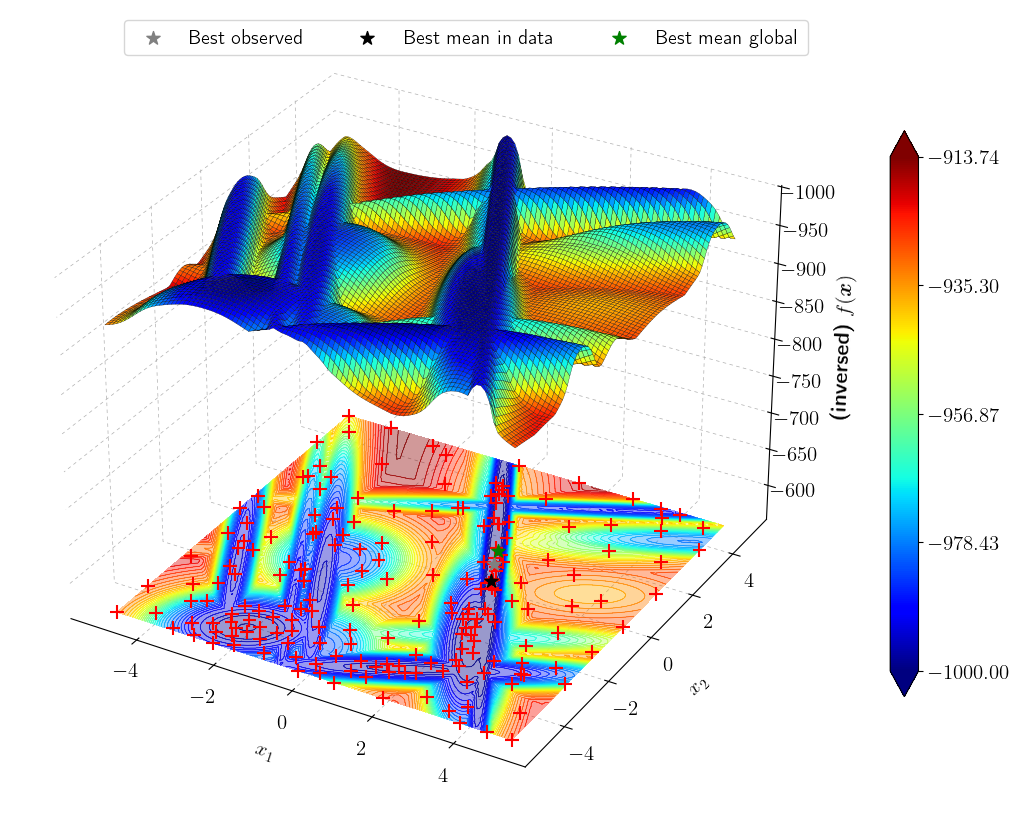

In [170]:
import FewShotCVRP.utils.plots as myplots

fig, ax = myplots.plot_3D_surface(
    (-5, 5),
    (-5, 5),
    f,
    res["X"],
    is_axis_names=True,
    is_white_facecolor=True,
    is_colorbar=True,
    discretization=100,
    zfactor=2.0,
    is_inverse=True,
)
zax_min, zax_max = ax.get_zlim()
ax.scatter(
    res["x_obs_best"][0],
    res["x_obs_best"][1],
    zax_min,
    c="grey",
    marker="*",
    s=100,
    alpha=1,
    zorder=4,
    label="Best observed",
)
ax.scatter(
    res["x_rec_mean_in_data"][0],
    res["x_rec_mean_in_data"][1],
    zax_min,
    c="black",
    marker="*",
    s=100,
    alpha=1,
    zorder=4,
    label="Best mean in data",
)
ax.scatter(
    res["x_rec_mean_global"][0],
    res["x_rec_mean_global"][1],
    zax_min,
    c="green",
    marker="*",
    s=100,
    alpha=1,
    zorder=4,
    label="Best mean global",
)
ax.legend(ncols=3)

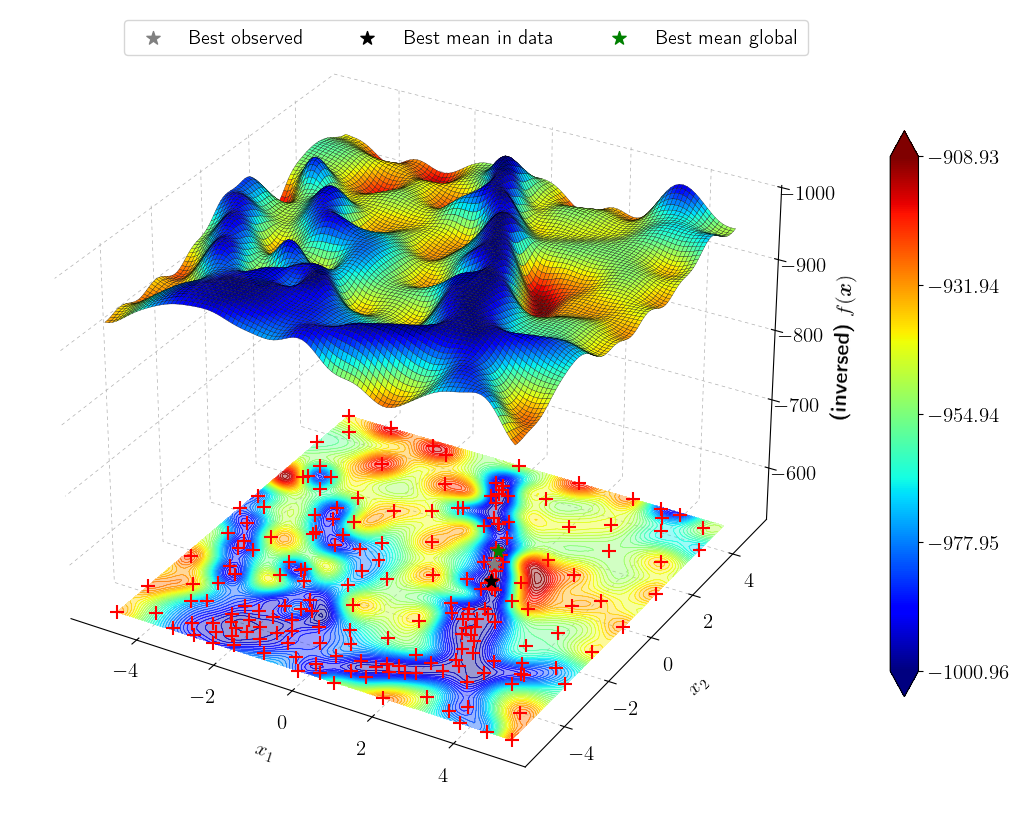

In [ ]:
import torch
from botorch.acquisition.analytic import PosteriorMean

pred = PosteriorMean(model=kpcabo_torch.get_gp(), maximize=True).to("cpu")
fig, ax = myplots.plot_3D_surface(
    (-5, 5),
    (-5, 5),
    lambda x: pred(torch.tensor(x.reshape(1, -1), dtype=torch.double))
    .detach()
    .numpy()
    .squeeze(0),
    res["X"],
    is_axis_names=True,
    is_white_facecolor=True,
    is_colorbar=True,
    discretization=100,
    zfactor=2.0,
    is_inverse=True,
)
zax_min, zax_max = ax.get_zlim()
ax.scatter(
    res["x_obs_best"][0],
    res["x_obs_best"][1],
    zax_min,
    c="grey",
    marker="*",
    s=100,
    alpha=1,
    zorder=4,
    label="Best observed",
)
ax.scatter(
    res["x_rec_mean_in_data"][0],
    res["x_rec_mean_in_data"][1],
    zax_min,
    c="black",
    marker="*",
    s=100,
    alpha=1,
    zorder=4,
    label="Best mean in data",
)
ax.scatter(
    res["x_rec_mean_global"][0],
    res["x_rec_mean_global"][1],
    zax_min,
    c="green",
    marker="*",
    s=100,
    alpha=1,
    zorder=4,
    label="Best mean global",
)
ax.legend(ncols=3)

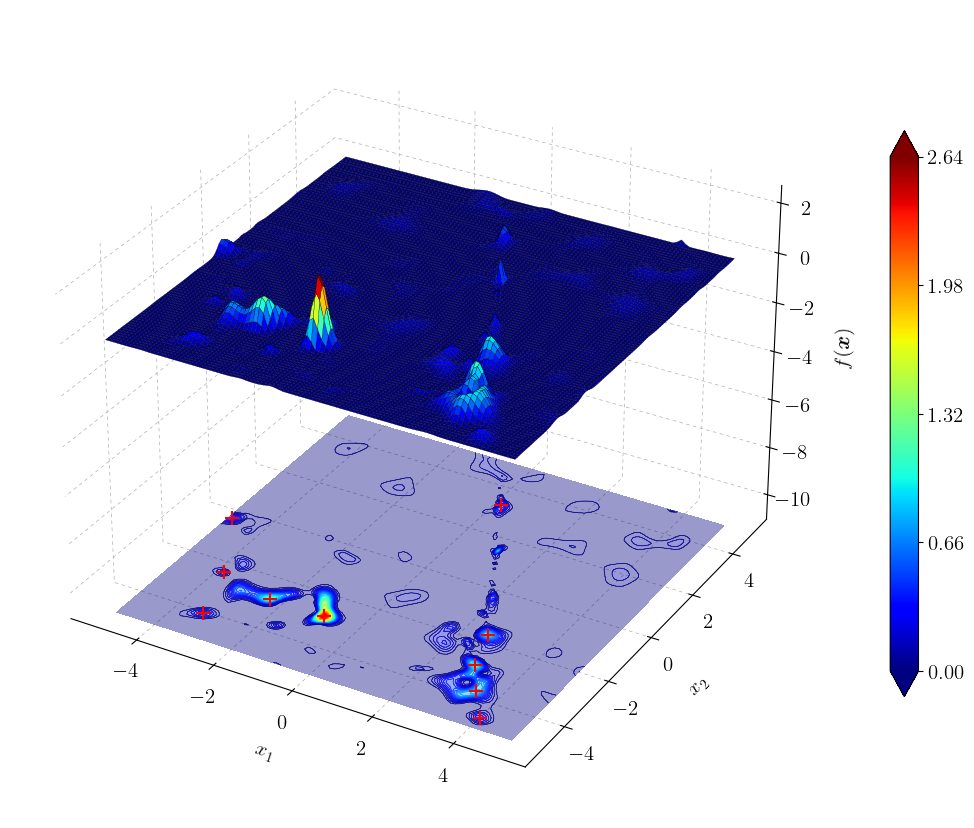

In [ ]:
cands, acqf = kpcabo_torch._argmax_acq_multi(kpcabo_torch.suggestions_per_step)

fig, ax = myplots.plot_3D_surface(
    (-5, 5),
    (-5, 5),
    lambda x: np.exp(acqf(
        bo_torch_mod._as_t([x], dtype=kpcabo_torch.dtype, device=kpcabo_torch.device)
    )
    .detach()
    .numpy()
    .squeeze(0)),
    bo_torch_mod._to_numpy64(cands),
    is_axis_names=True,
    is_white_facecolor=True,
    is_colorbar=True,
    discretization=100,
    zfactor=2.0,
    is_inverse=False,
)

In [ ]:
kpcabo_torch.get_length_scales(kpcabo_torch.get_gp())

array([0.04627682, 0.04627682])

### Kernel-PCA-BO

In [1]:
import warnings
from importlib import reload

from gpytorch.utils.warnings import NumericalWarning

import FewShotCVRP.bo.kpcabo.kpcabo_torch as kpcabo_torch

reload(kpcabo_torch)

warnings.filterwarnings("ignore", category=NumericalWarning)

kpcabo_torch = kpcabo_torch.KPCABayesianOptimizer(
    func=f,
    f_batch=None,
    kpca_eta=0.9,
    kpca_pad_frac=0.10,
    kpca_refit_trigger=0.20,
    max_preimage_anchors=3,
    preimage_budget=5000,
    n_init=50,
    n_iter=15,
    suggestions_per_step=10,
    bounds=np.array([[-5.0, 5.0], [-5.0, 5.0]]),
    random_state=1,
    bo_embedding_kwargs={
        "kernel": "rbf",
        "kernel_isotropic": True,
        "n_restarts_acq_opt": 100,
        "n_init_samples_acq_opt": 1000,
        "random_state": 1,
        "acq_function": "logEI",
        "diversity_frac": 0.1,
        "n_init": 50,
        "n_iter": 15,
        "doe_method": "lhs",
    },
)
res = kpcabo_torch.run()
print(res["X"].shape)
res

NameError: name 'f' is not defined

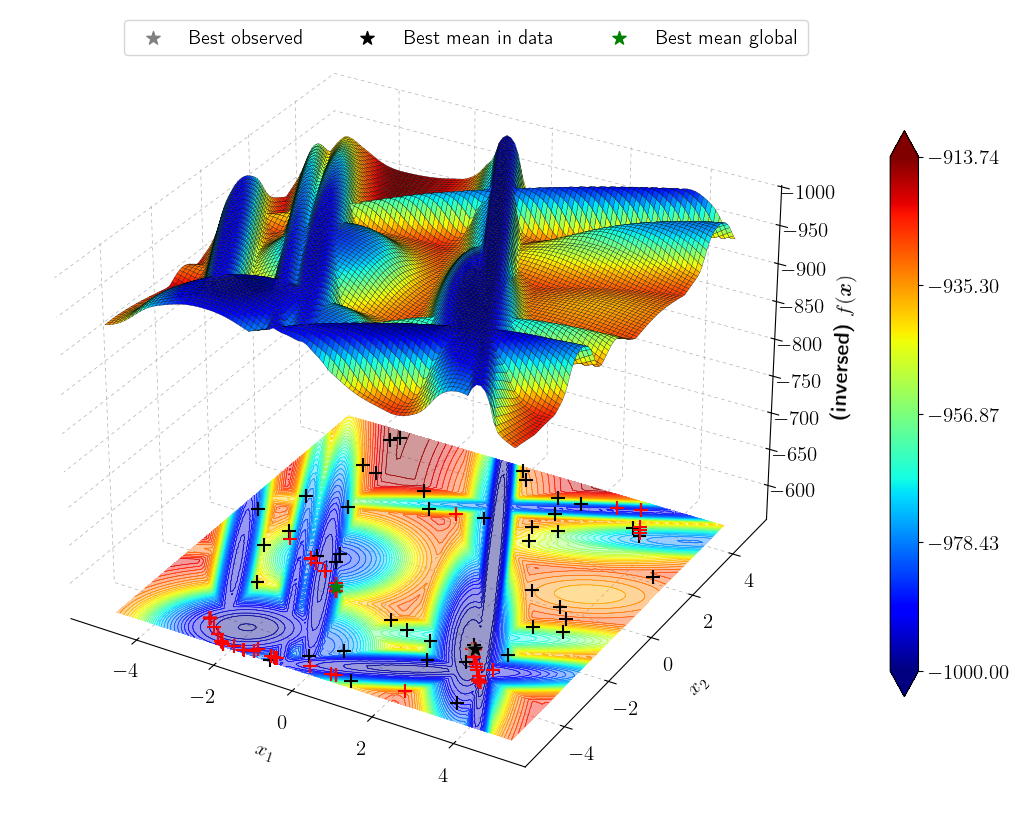

In [49]:
import FewShotCVRP.utils.plots as myplots

myplots.good_plt_config()
fig, ax = myplots.plot_3D_surface(
    (-5, 5),
    (-5, 5),
    f,
    res["X"][:50],
    is_axis_names=True,
    is_white_facecolor=True,
    is_colorbar=True,
    discretization=100,
    zfactor=2.0,
    is_inverse=True,
    scatter_search_space_color="black"
)
zax_min, zax_max = ax.get_zlim()
ax.scatter(
    res["X"][50:, 0],
    res["X"][50:, 1],
    zax_min,
    c="red",
    marker="+",
    s=100,
    alpha=1,
    zorder=4,
)
ax.scatter(
    res["x_obs_best"][0],
    res["x_obs_best"][1],
    zax_min,
    c="grey",
    marker="*",
    s=100,
    alpha=1,
    zorder=4,
    label="Best observed",
)
ax.scatter(
    res["x_rec_mean_in_data"][0],
    res["x_rec_mean_in_data"][1],
    zax_min,
    c="black",
    marker="*",
    s=100,
    alpha=1,
    zorder=4,
    label="Best mean in data",
)
ax.scatter(
    res["x_rec_mean_global"][0],
    res["x_rec_mean_global"][1],
    zax_min,
    c="green",
    marker="*",
    s=100,
    alpha=1,
    zorder=4,
    label="Best mean global",
)
ax.legend(ncols=3)